In [1]:
# For data collection 
import xarray as xr
# For data manipulation
import numpy as np
from scipy import stats
# For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean

In [3]:
#file_path = '/home/exf512/gdp_v2.00.nc'
file_path = '/Users/19082/Desktop/Shane/Drifter/gdp_v2.00.nc'
ds = xr.open_dataset(file_path)

In [4]:
ds

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ID                     (traj) int64 ...
    longitude              (obs) float32 ...
    latitude               (obs) float32 ...
    time                   (obs) datetime64[ns] ...
    ids                    (obs) int64 ...
Dimensions without coordinates: traj, obs
Data variables: (12/53)
    rowsize                (traj) int64 ...
    location_type          (traj) bool ...
    WMO                    (traj) int32 ...
    expno                  (traj) int32 ...
    deploy_date            (traj) datetime64[ns] ...
    deploy_lon             (traj) float32 ...
    ...                     ...
    err_sst                (obs) float32 ...
    err_sst1               (obs) float32 ...
    err_sst2               (obs) float32 ...
    flg_sst                (obs) int8 ...
    flg_sst1               (obs) int8 ...
    flg_sst2               (obs) int8 ...
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-01-14T11:16:01.998226
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

In [3]:
time_bin = ds.time.astype('float')/(1e9*3600*24*365) - 17.75 + 1988 # in years

In [4]:
bins = np.arange(1988.01,2020.78, 0.027) # bin every 10 days 

In [5]:
ds_sst = ds.time.where(ds.flg_sst==5).astype('float')/(1e9*3600*24*365) - 17.75 + 1988 # years 
ds_vn = ds.time.where(ds.vn.isnull() == False).astype('float')/(1e9*3600*24*365) - 17.75 + 1988 # years
ds_sst2 = ds.time.where(ds.flg_sst2 ==5).astype('float')/(1e9*3600*24*365) - 17.75 + 1988 # years

In [6]:
hist_sst, bin_edges_sst = np.histogram(ds_sst,bins=bins)
hist_vn, bin_edges_vn = np.histogram(ds_vn, bins=bins)
hist_sst2, bin_edges_sst2 = np.histogram(ds_sst2, bins=bins)

([<matplotlib.axis.XTick at 0x20084a4b0e90>,
 [Text(1988, 0, '1988'),
  Text(1990, 0, '1990'),
  Text(1992, 0, '1992'),
  Text(1994, 0, '1994'),
  Text(1996, 0, '1996'),
  Text(1998, 0, '1998'),
  Text(2000, 0, '2000'),
  Text(2002, 0, '2002'),
  Text(2004, 0, '2004'),
  Text(2006, 0, '2006'),
  Text(2008, 0, '2008'),
  Text(2010, 0, '2010'),
  Text(2012, 0, '2012'),
  Text(2014, 0, '2014'),
  Text(2016, 0, '2016'),
  Text(2018, 0, '2018'),
  Text(2020, 0, '2020')])

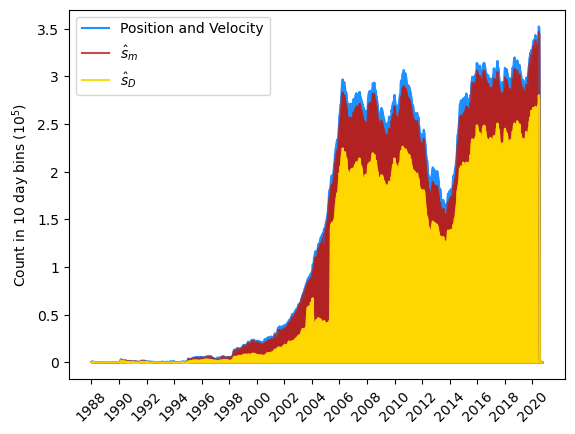

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
xticks = np.arange(1988, 2022, 2)
plt.plot(bin_edges_vn[0:-1],hist_vn, color = "dodgerblue", label = "Position and Velocity")
plt.plot(bin_edges_sst[0:-1],hist_sst, color = "firebrick", alpha = 0.8, label = "$\hat{s}$$_{m}$")
plt.plot(bin_edges_sst2[0:-1],hist_sst2, color = "gold", alpha = 0.95, label = "$\hat{s}$$_{D}$")
scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y)) # scale y-axis
ax.yaxis.set_major_formatter(ticks_y)
plt.legend(loc='upper left')
ax.set_ylabel("Count in 10 day bins (10$^5$)")
ax.set_xlabel("")
ax.fill_between(x = bins[0:-1], y1 = hist_vn, color = 'dodgerblue')
ax.fill_between(x = bins[0:-1], y1 = hist_sst, color = 'firebrick')
ax.fill_between(x = bins[0:-1], y1 = hist_sst2, color = 'gold')
plt.xticks(xticks, rotation = 45)
plt.savefig('density_histogram.pdf')

In [5]:
lon = np.linspace(-180,180, 360*2)
lat = np.linspace(-90, 90, 180*2)

ret1 = stats.binned_statistic_2d(ds.longitude, 
                                ds.latitude,
                                ds.sst,
                                statistic='count', 
                                bins= [lon, lat])
ret1.statistic.T[ret1.statistic.T == 0] = np.nan

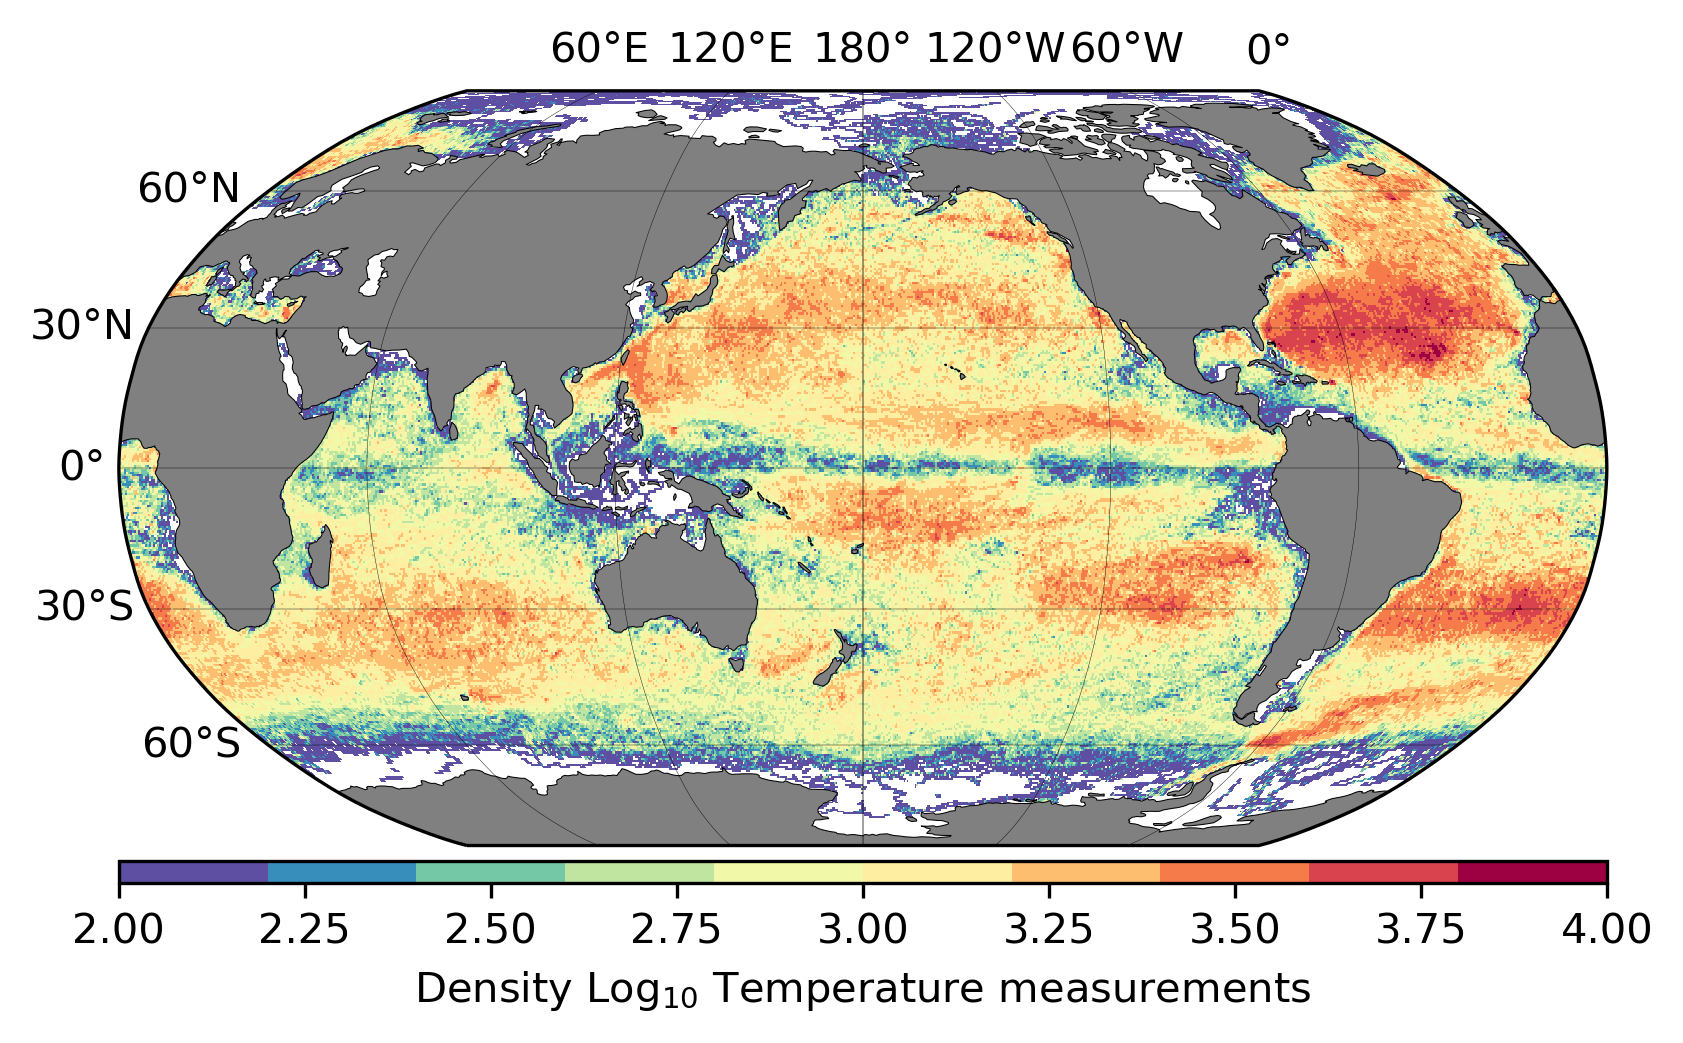

In [9]:
x_c = np.convolve(lon, [0.5, 0.5], mode='valid')
y_c = np.convolve(lat, [0.5, 0.5], mode='valid')


# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
sst1a, sst2a = np.nanpercentile(ret1.statistic.T,[1,99])  
cmap = plt.cm.get_cmap("Spectral_r", 10)

fig1 = plt.figure(dpi=300)
ax1 = fig1.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=-180))
image = plt.pcolormesh(x_c, y_c,
                       np.log10(ret1.statistic.T), 
                       cmap=cmap, 
                       transform=ccrs.PlateCarree(),
                       vmin=np.log10(sst1a), vmax=np.log10(sst2a)) 
plt.clim(2, 4)

# gridlines and labels
gl = ax1.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False

# add land and coastline
ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig1.colorbar(image, cax=cax, orientation = "horizontal");
cb.ax.set_xlabel('Density Log$_{10}$ Temperature measurements');
plt.savefig('density_map.pdf')